<a href="https://colab.research.google.com/github/nklbigone/DIC-ML/blob/main/Sprint10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [4]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


## **[Problem 1] Classifying fully connected layers**

In [6]:
class FC:
    
     """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    
     def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
       
        self.X = None
        self.dZ = None
        
    
     def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.X = X
        A = X.dot(self.W) + self.B

        return A
    
    
     def backward(self, dA):
        
       """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
       self.dZ = np.dot(dA, self.W.T)
       self.dB = np.sum(dA, axis=0)
       self.dW = np.dot(self.X.T, dA)
       self.optimizer.update(self)
          
       return self.dZ

## **[Problem 2] Classifying the initialization method**

In [7]:
class SimpleInitializer():
    
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    
    def __init__(self, sigma=0.01):
        
        self.sigma = sigma
        
        
    def W(self, n_nodes1, n_nodes2):
        
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W :
        """
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        
        """
        バイアスの初期化
        
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
          
        Returns
        ----------
        B :float
            バイアスの初期値
            
        """
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

## **[Problem 3] Classifying optimization methods**

In [8]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        Update weights and biases for a layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

## **[Problem 4] Classifying activation functions**

In [9]:
class Tanh:
         
    def forward(self, A):

        self.Z = (np.exp(A) - np.exp(-A)) / (np.exp(A) + np.exp(-A))
        return self.Z
    
    
    def backward(self, dZ):
        
        dA = dZ*(1 - self.Z)**2
        return dA

In [10]:
class Softmax:
    
    def forward(self, A):
        
        A = A - np.max(A, axis=1, keepdims=True)
        Z = np.exp(A) / np.sum(np.exp(A), axis=1, keepdims=True)
        return Z
        
        
    def backward(self, dZ, Y):
        
        batch_size = dZ.shape[0]
        dA = (dZ - Y) / batch_size
        
        loss = (-1)*np.sum(Y * np.log(dZ + 1e-7))  / batch_size
        
        
        return dA, loss


## **[Problem 5] ReLU class creation**

In [11]:
class ReLU:
    
    
    def __init__(self):
        
        self.mask = None
    
    
    def forward(self, A):

        self.mask = (A <= 0)
        Z = np.maximum(0, A)
        return Z
        
    
    def backward(self, dA):
        
        dA[self.mask] = 0
        return dA

## **[Problem 6] Initial value of weight**

In [12]:
class XavierInitializer:
    
    def __init__(self, sigma):
        
        self.sigma = sigma
        
            
    def W(self, n_nodes1, n_nodes2):
        self.n_nodes1 = n_nodes1
        self.sigma = 1 / np.sqrt(n_nodes1)
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        self.sigma = 1 / np.sqrt(self.n_nodes1)
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [13]:
class HeInitializer:
    def __init__(self, sigma):
        
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.n_nodes1 = n_nodes1
        sigma = np.sqrt(2 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    
    def B(self, n_nodes2):
        
        sigma = np.sqrt(2 / self.n_nodes1)
        B = sigma * np.random.randn(n_nodes2)
        
        return B

## **[Problem 7] Optimization method**

In [14]:
class AdaGrad():
    def __init__(self, lr):
        
        self.lr = lr
        self.hW = 1.
        self.hB = 1.
        
    def update(self, layer):
        self.hW += np.mean(layer.dW, axis=0)**2
        self.hB += ((np.mean(layer.dB, axis=0))**2).sum(axis=0)
        
        layer.W -= (self.lr / np.sqrt(self.hW)) * layer.dW
        layer.B -= (self.lr / np.sqrt(self.hB)) * layer.dB

In [15]:
class GetMiniBatch:
    
    def __init__(self, X, y, batch_size = 20, seed=0):
        
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
        
    def __len__(self):
        return self._stop
    
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    
    
    def __iter__(self):
        self._counter = 0
        return self
    
    
    def __next__(self):
        
        if self._counter >= self._stop:
            raise StopIteration()
            
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## **[Problem 8] Class completion**

In [16]:
class ScratchDeepNeuralNetrowkClassifier():
   
    def __init__(self, initializer, optimizer, activator1, activator2, lr = 0.01,  batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, sigma=0.01, n_epochs=20, verbose = True):
        
        self.verbose = verbose
        
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        self.FC1 = None
        self.FC2 = None
        self.FC3 = None
        
        self.initializer = initializer
        self.optimizer = optimizer
        self.lr = lr
        
        self.activator1 = activator1
        self.activator2 = activator2   
        
        self.sigma = sigma
        
        self.loss = None
        self.val_loss = None
        
        self.loss_hist = []
        self.val_loss_hist = []
# Function to process for one epoch during training
        
    def forward_and_backward(self, X, y):
        
        Y = np.identity(10)[y]
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)

        dA3, self.loss = self.activation3.backward(Z3, Y) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1)

    def forward_with_loss(self, X, y):
        
        Y = np.identity(10)[y]
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        dA3, self.val_loss = self.activation3.backward(Z3, Y) 
        
    
    def fit(self, X, y, X_val=None, y_val=None):
        
        
        
        # Generate all nodes first
        self.FC1 = FC(self.n_features, self.n_nodes1, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation1 = self.activator1
    
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation2 = self.activator2
        
        self.FC3 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr))
        self.activation3 = Softmax()
        # Generate a mini-batch of training data
        get_mini_batch_train = GetMiniBatch(X, y, batch_size=self.batch_size)
        
        get_mini_batch_val = GetMiniBatch(X_val, y_val, batch_size=self.batch_size)
        
        for epoch in range(self.n_epochs):
            
            for mini_X_train, mini_y_train in get_mini_batch_train:
                self.forward_and_backward(mini_X_train, mini_y_train)
                
            self.loss_hist.append(self.loss)
            mini_X_val, mini_y_val = get_mini_batch_val[0]
            self.forward_with_loss(mini_X_val, mini_y_val)
            self.val_loss_hist.append(self.val_loss)
        
            
            if self.verbose:

                print('#'*25)
                print('### Epoch %i'%(epoch+1))
                print('#'*25)
                
                print("Loss of training data : {}".format(self.loss))
                print("Loss of validation data : {}".format(self.val_loss))
                
                print()
                
                
    
    def predict(self, X):
        
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        
        pred = Z3.argmax(axis=1)
        return pred

## **[Problem 9] Learning and estimation**

In [17]:
dnn = ScratchDeepNeuralNetrowkClassifier(initializer=SimpleInitializer, optimizer = SGD, lr=0.001,  sigma=0.01, activator1=Tanh(),  activator2=Tanh(), n_epochs=20, verbose = True)

In [18]:
dnn.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
Loss of training data : 2.29509892760332
Loss of validation data : 2.297509889515573

#########################
### Epoch 2
#########################
Loss of training data : 2.2841648422963816
Loss of validation data : 2.28895726666194

#########################
### Epoch 3
#########################
Loss of training data : 2.2487012551632644
Loss of validation data : 2.2590948120475565

#########################
### Epoch 4
#########################
Loss of training data : 2.066140229101051
Loss of validation data : 2.1192522948507055

#########################
### Epoch 5
#########################
Loss of training data : 1.9048511609295353
Loss of validation data : 1.9754133961947749

#########################
### Epoch 6
#########################
Loss of training data : 1.7571778643048224
Loss of validation data : 2.0309266018920233

#########################
### Epoch 7
#########################
Loss of training data : 

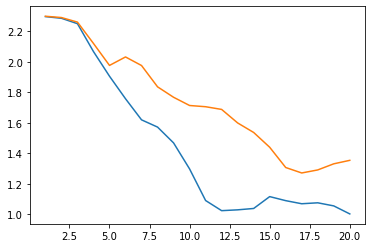

In [19]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, dnn.n_epochs+1), dnn.loss_hist)
plt.plot(np.arange(1, dnn.n_epochs+1), dnn.val_loss_hist)

plt.show()

In [20]:
y_pred = dnn.predict(X_test)
y_pred

array([7, 2, 1, ..., 9, 9, 6])

In [21]:
from sklearn.metrics import accuracy_score
accuracy3 = accuracy_score(y_test, y_pred)
accuracy3

0.6397

In [22]:
dnn4 = ScratchDeepNeuralNetrowkClassifier(initializer=HeInitializer,optimizer = SGD, lr=0.001,  sigma=0.01, activator1=ReLU(), activator2=ReLU(), n_epochs=20, verbose = True)

In [23]:
dnn4.fit(X_train, y_train, X_val, y_val)

#########################
### Epoch 1
#########################
Loss of training data : 0.8552549175658692
Loss of validation data : 0.8577082003273591

#########################
### Epoch 2
#########################
Loss of training data : 0.4844739161937796
Loss of validation data : 0.5424910908938088

#########################
### Epoch 3
#########################
Loss of training data : 0.36098834697323373
Loss of validation data : 0.432551431253808

#########################
### Epoch 4
#########################
Loss of training data : 0.3078627143649708
Loss of validation data : 0.37539893432479166

#########################
### Epoch 5
#########################
Loss of training data : 0.2805794107083782
Loss of validation data : 0.3412497930634476

#########################
### Epoch 6
#########################
Loss of training data : 0.2646986399768208
Loss of validation data : 0.31918925011361915

#########################
### Epoch 7
#########################
Loss of training

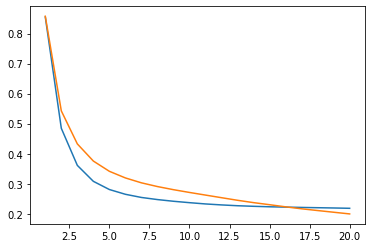

In [24]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, dnn4.n_epochs+1), dnn4.loss_hist)
plt.plot(np.arange(1, dnn4.n_epochs+1), dnn4.val_loss_hist)

plt.show()

In [25]:
y_pred4 = dnn4.predict(X_test)
y_pred4

array([7, 2, 1, ..., 4, 5, 6])

In [26]:
from sklearn.metrics import accuracy_score

accuracY = accuracy_score(y_test, y_pred)
accuracY

0.6397